In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,64
41,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,61


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 140, 149, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 60,
 64,
 98,
 106,
 140,
 149,
 179,
 180,
 240,
 248,
 253,
 257,
 287,
 309,
 322,
 326]

In [8]:
def plot_similarity_heatmap(dtw_df):
    vis_right_df = play_record_df.copy()
    vis_right_df = vis_right_df[['drummer_name', 'id']]

    vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
    vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
    vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
    vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                      'drummer_name_y': 'b_drummer_name'})
    vis_df['a_id'] = vis_df['a_id'].apply(str)
    vis_df['b_id'] = vis_df['b_id'].apply(str)
    vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# raw merge

In [9]:
dtw_df = pd.read_csv('dtw_df@raw_split.csv')
dtw_df

,a_id,b_id,L_acc_dtw,L_gyr_dtw,R_acc_dtw,R_gyr_dtw
0,1,5,25435.976923,234446.687036,27311.047252,488650.485275
1,1,33,22999.915519,243205.659485,40797.928177,574580.796336
2,1,37,23403.894706,255774.107370,39801.448732,563563.171640
3,1,60,21345.670708,260698.685118,40614.286488,523166.679476
4,1,64,21830.676678,256992.132905,40560.365201,499523.654722
5,1,98,25712.726355,337514.767055,42699.517888,603696.026837
6,1,106,28617.121278,355697.412281,42643.804867,606281.756820
7,1,140,25989.992809,289887.171976,43886.443442,549840.286465
8,1,149,24496.050067,324832.518280,40440.468705,578943.023205
9,1,179,37808.130064,472114.957708,55961.644671,744346.059440


In [10]:
SIMILARITY_COLUMNS = list(dtw_df.drop(['a_id', 'b_id'], axis=1).columns)
SIMILARITY_COLUMNS

['L_acc_dtw', 'L_gyr_dtw', 'R_acc_dtw', 'R_gyr_dtw']

In [11]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,L_acc_dtw,L_gyr_dtw,R_acc_dtw,R_gyr_dtw,norm_sim
0,1,5,-0.252845,-0.858797,-0.471881,0.215042,-0.342120
1,1,33,-0.486025,-0.805648,0.899278,0.810125,0.104433
2,1,37,-0.447356,-0.729383,0.797970,0.733825,0.088764
3,1,60,-0.644368,-0.699501,0.880608,0.454072,-0.002297
4,1,64,-0.597944,-0.721992,0.875126,0.290340,-0.038617
5,1,98,-0.226355,-0.233384,1.092605,1.011753,0.411155
6,1,106,0.051653,-0.123053,1.086941,1.029659,0.511300
7,1,140,-0.199815,-0.522386,1.213275,0.638792,0.282466
8,1,149,-0.342815,-0.310340,0.862937,0.840334,0.262529
9,1,179,0.931414,0.583364,2.440914,1.985780,1.485368


In [12]:
dtw_df[dtw_df['a_id'] == 60]


,a_id,b_id,L_acc_dtw,L_gyr_dtw,R_acc_dtw,R_gyr_dtw,norm_sim
76,60,1,-0.640254,-0.748475,0.819234,0.454026,-0.028867
77,60,5,-1.033517,-1.199423,0.654563,0.619291,-0.239772
78,60,33,-1.078226,-1.456609,-1.537215,-1.435540,-1.376897
79,60,37,-1.538589,-1.532425,-1.739276,-1.494094,-1.576096
80,60,64,-1.947934,-1.753517,-2.205635,-1.543861,-1.862737
81,60,98,-1.237905,-0.952487,-1.431971,-1.029762,-1.163031
82,60,106,-1.102100,-0.708177,-1.264252,-0.817076,-0.972901
83,60,140,-1.148301,-1.337424,-0.610348,-1.456915,-1.138247
84,60,149,-1.449903,-1.027329,-1.987463,-1.730696,-1.548848
85,60,179,0.016161,0.187905,0.165936,0.401630,0.192908


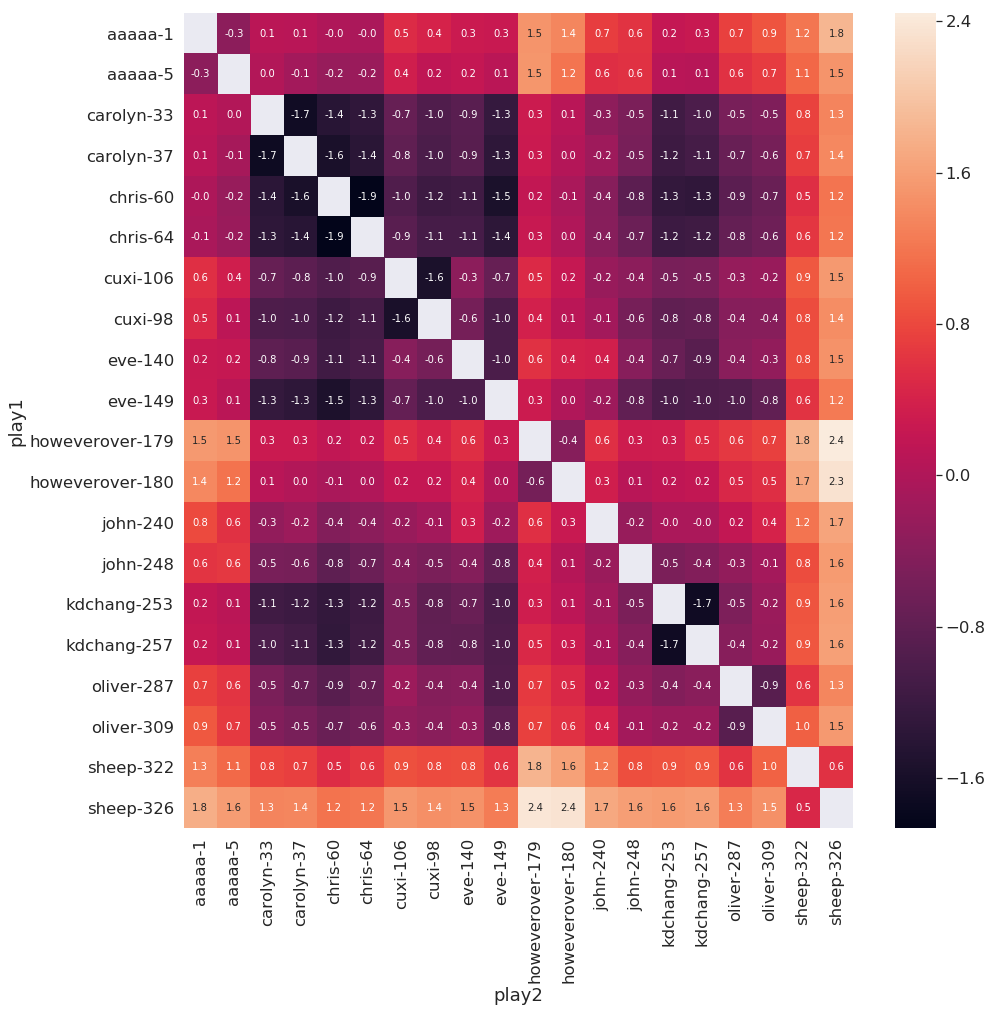

In [13]:
plot_similarity_heatmap(dtw_df)

In [14]:
dtw_df = pd.read_csv('dtw_df@raw_merge.csv')

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

KeyError: "['L_acc_dtw' 'L_gyr_dtw' 'R_acc_dtw' 'R_gyr_dtw'] not in index"

In [ ]:
plot_similarity_heatmap(dtw_df)

# raw merge euc

In [ ]:
dtw_df = pd.read_csv('dtw_df@raw_merge_euc.csv')
dtw_df

In [ ]:
SIMILARITY_COLUMNS = list(dtw_df.drop(['a_id', 'b_id'], axis=1).columns)
SIMILARITY_COLUMNS

In [ ]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

In [ ]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')